In [ ]:
import pandas as pd
import numpy as np
import string

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline

In [ ]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import spacy

import matplotlib.pyplot as plt
import seaborn as sns


/opt/conda/lib/python3.10/site-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 55)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [ ]:
import pandas as pd
from datasets import load_dataset


dataset = load_dataset('mavinsao/reddit-mental-illness-82')
df = dataset['train'].to_pandas()
df['text'] = df['text'].str.lower()

keywords = [
    "think i have", "i think i have", "i think it might be", "i think i could have",
    "might have", "i might have", "might be", "feel like i have", "i feel like i have",
    "feels like i have", "self-diagnose", "self-diagnosed", "i've self-diagnosed",
    "unsure if i have", "i'm unsure if", "unsure if this is", "wonder if i have",
    "i wonder if i have", "wonder if it's", "symptoms of", "i have symptoms of",
    "experiencing symptoms of", "suspect i have", "i suspect i have", "i suspect it's",
    "probably have", "i probably have", "i think i probably have", "could be", "it could be",
    "seems like i have", "it seems like i have", "it seems like", "not diagnosed but",
    "i am not diagnosed but", "i haven't been diagnosed but"
]

df = df[~df['text'].str.contains('|'.join(keywords), case=False, na=False)]

# Розбиття тексту на заголовок і основний текст
def split_text(row):
    if ':' in row:
        parts = row.split(':', 1)
        return parts[0].strip(), parts[1].strip()
    return None, row.strip()

df[['title', 'main_text']] = df['text'].apply(split_text).apply(pd.Series)


print(df[['title', 'main_text', 'label']])


Generating train split:   0%|          | 0/42113 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/5264 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/5265 [00:00<?, ? examples/s]

                                                   title  \
0                              fantasizing about your fp   
1      this is a support subreddit for people with a ...   
2                        scared of my psychotic symptoms   
4      i feel like a sick animal that needs to be put...   
5      is constantly checking ocd subreddits a compul...   
...                                                  ...   
42108  16m suicidal, lonely, need to feel loved befor...   
42109                               got asked on a date!   
42110         i just found out my friend killed herself.   
42111  family letter detailing the conditions and lib...   
42112                     i'm very proud of myself today   

                                               main_text  label  
0      do you do it? what do you fantasize about? : w...      3  
1      it's not for posting how infuriating the uneve...      6  
2      i'm trying to keep reminding myself that what ...      2  
4      i had a 

In [ ]:
import pandas as pd
from nltk.corpus import stopwords
import spacy

# Функція очищення тексту
def clean_text(text):
    text = text.str.lower()
    text = text.str.replace(r'[^\w\s]', '', regex=True)
    text = text.str.replace("\n", '', regex=True)
    text = text.str.replace('\d', '', regex=True)
    text = text.str.replace(r'\[.*?\]', '', regex=True)
    text = text.str.replace(r'https?://\S+|www\.\S+', '', regex=True)
    text = text.str.replace(r'<.*?>+', '', regex=True)
    text = text.str.replace(r'\w*\d\w*', '', regex=True)
    return text

# Функція видалення стоп-слів
# custom_stopwords = {'ocd', 'anxiety', 'adhd', 'ptsd', 'bpd', 'depression', 'bipolar'}
custom_stopwords = {}
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    stop_words.update(custom_stopwords)
    text = text.apply(lambda x: " ".join(word for word in str(x).split() if word.lower() not in stop_words))
    return text

# Функція лематизації
nlp = spacy.load('en_core_web_sm')

def lemmatize_sentence(sentence):
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc])

#до обох стовпців
def process_text_columns(df, columns):
    for col in columns:
        df[col] = clean_text(df[col])
        df[col] = remove_stopwords(df[col])
        delete = pd.Series(' '.join(df[col]).split()).value_counts()[-1000:]
        df[col] = df[col].apply(lambda x: " ".join(word for word in x.split() if word.lower() not in delete))
        df[col] = df[col].apply(lemmatize_sentence)
    return df

df = pd.DataFrame(df)
df = process_text_columns(df, ['title', 'main_text'])
print(df)


                                                    text  label  \
0      fantasizing about your fp: do you do it? what ...      3   
1      this is a support subreddit for people with a ...      6   
2      scared of my psychotic symptoms : i'm trying t...      2   
4      i feel like a sick animal that needs to be put...      4   
5      is constantly checking ocd subreddits a compul...      6   
...                                                  ...    ...   
42108  16m suicidal, lonely, need to feel loved befor...      4   
42109  got asked on a date! : and by a girl i already...      1   
42110  i just found out my friend killed herself. : i...      3   
42111  family letter detailing the conditions and lib...      5   
42112  i'm very proud of myself today : i had an exam...      3   

                                                   title  \
0                                           fantasize fp   
1                support subreddit people mental illness   
2              

In [ ]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split




# основний текст
# df['text'] = df['title'].str.strip(':') + ' ' + df['main_text']
df['text'] = df['main_text']

X = df['text']
y = df['label']


undersampler = RandomUnderSampler(sampling_strategy='auto', random_state=42)
X_res, y_res = undersampler.fit_resample(X.values.reshape(-1, 1), y)
print("Розподіл класів після балансування:")
print(pd.Series(y_res).value_counts())
balanced_df = pd.DataFrame({
    'text': X_res.flatten(),
    'label': y_res
})

# тренувальний та тестовий набори
train_df, test_df = train_test_split(balanced_df, test_size=0.2, random_state=42)

print("\nРозподіл класів у тренувальному наборі:")
print(train_df['label'].value_counts())
print("\nРозподіл класів у тестовому наборі:")
print(test_df['label'].value_counts())


Розподіл класів після балансування:
label
0    3257
1    3257
2    3257
3    3257
4    3257
5    3257
6    3257
7    3257
Name: count, dtype: int64

Розподіл класів у тренувальному наборі:
label
5    2624
3    2622
7    2616
6    2615
0    2615
4    2604
1    2586
2    2562
Name: count, dtype: int64

Розподіл класів у тестовому наборі:
label
2    695
1    671
4    653
0    642
6    642
7    641
3    635
5    633
Name: count, dtype: int64


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import LabelEncoder

tfidf_vectorizer = TfidfVectorizer()
X_train = tfidf_vectorizer.fit_transform(train_df['text'])
X_test = tfidf_vectorizer.transform(test_df['text'])
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

# Логістична регресія
logistic_regression_classifier = LogisticRegression(max_iter=1000, random_state=42)
logistic_regression_classifier.fit(X_train, y_train)

y_test_pred = logistic_regression_classifier.predict(X_test)


print("Test Set Evaluation:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred)}")
print(classification_report(y_test, y_test_pred))

Test Set Evaluation:
Accuracy: 0.749424405218726
              precision    recall  f1-score   support

           0       0.76      0.81      0.78       642
           1       0.72      0.68      0.70       671
           2       0.77      0.65      0.71       695
           3       0.67      0.70      0.69       635
           4       0.62      0.71      0.66       653
           5       0.83      0.98      0.90       633
           6       0.88      0.78      0.83       642
           7       0.77      0.70      0.73       641

    accuracy                           0.75      5212
   macro avg       0.75      0.75      0.75      5212
weighted avg       0.75      0.75      0.75      5212



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def tokenize_data(texts, tokenizer, max_len):
    return tokenizer(texts, padding=True, truncation=True, max_length=max_len, return_tensors="pt")

max_len = 256
train_encodings = tokenize_data(train_df['text'].tolist(), tokenizer, max_len)
test_encodings = tokenize_data(test_df['text'].tolist(), tokenizer, max_len)

label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

class TextDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

train_dataset = TextDataset(train_encodings, y_train)
test_dataset = TextDataset(test_encodings, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_)).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5)
epochs = 3

total_steps = len(train_loader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
def train_model(model, train_loader, optimizer, scheduler, device, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        correct_predictions = 0
        total_predictions = 0
        for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            batch = {k: v.to(device) for k, v in batch.items()}

            optimizer.zero_grad()
            outputs = model(**batch)
            loss = outputs.loss
            logits = outputs.logits

            loss.backward()
            optimizer.step()
            scheduler.step()

            total_loss += loss.item()
            predictions = torch.argmax(logits, dim=-1)
            correct_predictions += (predictions == batch['labels']).sum().item()
            total_predictions += batch['labels'].size(0)

        avg_loss = total_loss / len(train_loader)
        accuracy = correct_predictions / total_predictions
        print(f"Epoch {epoch + 1}/{epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

train_model(model, train_loader, optimizer, scheduler, device, epochs)

def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Evaluating"):
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(batch['labels'].cpu().numpy())

    return all_preds, all_labels

y_test_pred, y_test_labels = evaluate_model(model, test_loader, device)
print("BERT Transformer Model Evaluation:")
print(f"Accuracy: {accuracy_score(y_test_labels, y_test_pred)}")
print(classification_report(y_test_labels, y_test_pred))



Using device: cuda


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Please use a different name to suppress this warning.
A parameter name that contains `beta` will be renamed internally to `bias`. Please use a different name to suppress this warning.
A parameter name that contains `gamma` will be renamed internally to `weight`. Pl

Epoch 1/3 - Loss: 0.9528, Accuracy: 0.6789


Epoch 2/3: 100%|██████████| 1303/1303 [16:30<00:00,  1.32it/s]


Epoch 2/3 - Loss: 0.6108, Accuracy: 0.8008


Epoch 3/3: 100%|██████████| 1303/1303 [16:29<00:00,  1.32it/s]


Epoch 3/3 - Loss: 0.4471, Accuracy: 0.8582


Evaluating: 100%|██████████| 326/326 [01:23<00:00,  3.88it/s]

BERT Transformer Model Evaluation:
Accuracy: 0.782233307751343
              precision    recall  f1-score   support

           0       0.83      0.83      0.83       642
           1       0.73      0.74      0.74       671
           2       0.77      0.69      0.73       695
           3       0.72      0.70      0.71       635
           4       0.67      0.70      0.68       653
           5       0.96      0.98      0.97       633
           6       0.80      0.82      0.81       642
           7       0.78      0.80      0.79       641

    accuracy                           0.78      5212
   macro avg       0.78      0.78      0.78      5212
weighted avg       0.78      0.78      0.78      5212



Using device: cuda
Epoch 1/50, Loss: 1.9333, Accuracy: 0.2373
Epoch 2/50, Loss: 1.6774, Accuracy: 0.3626
Epoch 3/50, Loss: 1.4873, Accuracy: 0.4539
Epoch 4/50, Loss: 1.4284, Accuracy: 0.4913
Epoch 5/50, Loss: 1.4903, Accuracy: 0.4456
Epoch 6/50, Loss: 1.3385, Accuracy: 0.5214
Epoch 7/50, Loss: 1.2585, Accuracy: 0.5575
Epoch 8/50, Loss: 1.1742, Accuracy: 0.5905
Epoch 9/50, Loss: 1.0960, Accuracy: 0.6236
Epoch 10/50, Loss: 1.3162, Accuracy: 0.5248
Epoch 11/50, Loss: 1.3917, Accuracy: 0.4732
Epoch 12/50, Loss: 1.2598, Accuracy: 0.5251
Epoch 13/50, Loss: 1.1539, Accuracy: 0.5651
Epoch 14/50, Loss: 1.0717, Accuracy: 0.6037
Epoch 15/50, Loss: 1.0040, Accuracy: 0.6436
Epoch 16/50, Loss: 0.8926, Accuracy: 0.6900
Epoch 17/50, Loss: 0.8001, Accuracy: 0.7246
Epoch 18/50, Loss: 0.7312, Accuracy: 0.7537
Epoch 19/50, Loss: 0.6720, Accuracy: 0.7761
Epoch 20/50, Loss: 0.6265, Accuracy: 0.7904
Epoch 21/50, Loss: 0.5589, Accuracy: 0.8189
Epoch 22/50, Loss: 0.5119, Accuracy: 0.8379
Epoch 23/50, Loss: 0.4

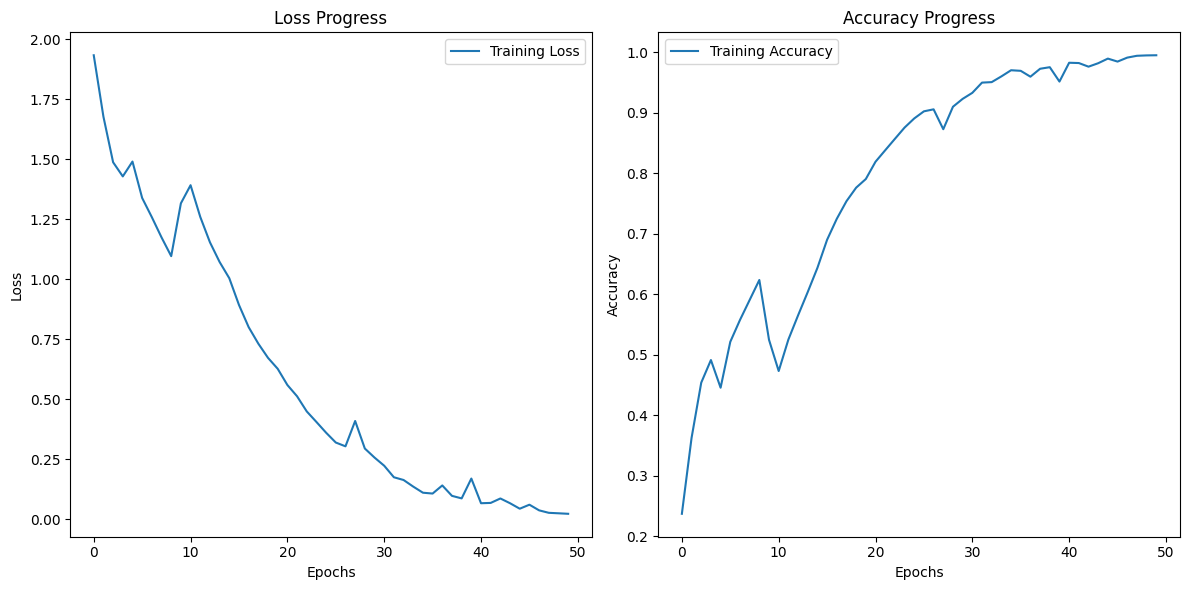

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])

X_train = tokenizer.texts_to_sequences(train_df['text'])
X_test = tokenizer.texts_to_sequences(test_df['text'])
max_len = max(len(x) for x in X_train + X_test)

X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_df['label'])
y_test = label_encoder.transform(test_df['label'])

class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = torch.tensor(texts, dtype=torch.long)
        self.labels = torch.tensor(labels, dtype=torch.long)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)
class LSTMClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, lstm_units, output_dim, dropout_rate):
        super(LSTMClassifier, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, lstm_units, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(lstm_units, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        x = self.embedding(x)
        x, _ = self.lstm(x)
        x = self.dropout(x[:, -1, :])
        x = self.fc(x)
        return x

# Ініціалізація моделі
vocab_size = len(tokenizer.word_index) + 1
embed_dim = 100
lstm_units = 100
output_dim = 8
dropout_rate = 0.2

model = LSTMClassifier(vocab_size, embed_dim, lstm_units, output_dim, dropout_rate).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Тренування
def train_model(model, train_loader, optimizer, criterion, device, epochs):
    history = {'loss': [], 'val_loss': [], 'accuracy': [], 'val_accuracy': []}
    for epoch in range(epochs):
        model.train()
        train_loss, correct = 0, 0
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = correct / len(train_loader.dataset)
        history['loss'].append(train_loss / len(train_loader))
        history['accuracy'].append(train_acc)

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {train_loss / len(train_loader):.4f}, Accuracy: {train_acc:.4f}")
    return history

history = train_model(model, train_loader, optimizer, criterion, device, epochs=50)
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for texts, labels in test_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            preds = outputs.argmax(1).cpu().numpy()
            all_preds.extend(preds)
            all_labels.extend(labels.cpu().numpy())
    return all_preds, all_labels

y_test_pred, y_test_labels = evaluate_model(model, test_loader, device)

print("RNN (LSTM) Evaluation:")
print(f"Accuracy: {accuracy_score(y_test_labels, y_test_pred)}")
print(classification_report(y_test_labels, y_test_pred))

def plot_training_progress(history):
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.title('Loss Progress')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history['accuracy'], label='Training Accuracy')
    plt.title('Accuracy Progress')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

plot_training_progress(history)
